In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
manualSeed=999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/Project"
workers = 2
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 1
Z_DIM = 100
FEATURES_G = 32
FEATURES_D = 32
NUM_EPOCHS = 25
LEARNING_RATE = 2e-4
beta1 = 0.5
ngpu=1

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                     transform=transforms.Compose([
                        transforms.Resize(IMAGE_SIZE),
                        transforms.CenterCrop(IMAGE_SIZE),
                        transforms.Grayscale(num_output_channels=1),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5 for _ in range(CHANNELS)],[0.5 for _ in range(CHANNELS)])
                     ]))

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

In [ ]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda')

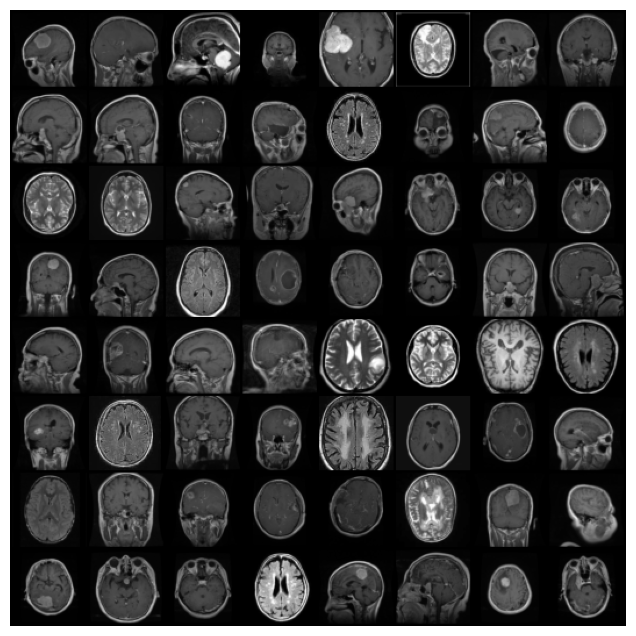

In [ ]:
# Plotting Training Images

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!= -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm')!= -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data,0)

In [ ]:
# class Encoder(nn.Module):
#   def __init__(self, ngpu):
#     super(Encoder, self).__init__()
#     self.ngpu = ngpu
#     self.main = nn.Sequential(
#         nn.Conv2d(CHANNELS, 64, 4, 2, 1),
#         nn.LeakyReLU(0.2, inplace = True),
#         nn.Conv2d(64, 128, 4, 2, 1),
#         nn.BatchNorm2d(128),
#         nn.LeakyReLU(0.2, inplace = True),
#         nn.Conv2d(128, 256, 4, 2, 1),
#         nn.BatchNorm2d(256),
#         nn.LeakyReLU(0.2, inplace = True)
#         )
#     self.fc = nn.Sequential(
#         nn.Linear(256*4*4, 1024),
#         nn.BatchNorm1d(1024),
#         nn.LeakyReLU(0.2, inplace = True),
#         nn.Linear(1024, Z_DIM)
#     )
#   def forward(self, x):
#     x = self.encoder(x)
#     x = x.view(x.size(0), -1)
#     x = self.fc(x)
#     return x

In [ ]:
# enc = Encoder(ngpu).to(device)

# if (device == 'cuda') and (ngpu > 1):
#   enc = nn.DataParallel(enc, list(range(ngpu)))

# print(enc)

In [ ]:
class Generator(nn.Module):
  def __init__(self,ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.ConvTranspose2d(Z_DIM, FEATURES_G*8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(FEATURES_G*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(FEATURES_G*8, FEATURES_G*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_G*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(FEATURES_G*4, FEATURES_G*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_G*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(FEATURES_G*2, FEATURES_G, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_G),
        nn.ReLU(True),
        nn.ConvTranspose2d(FEATURES_G, CHANNELS, 4, 2, 1, bias = False),
        nn.Tanh()
        )
  def forward(self,input):
    return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)

if(device == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.Conv2d(CHANNELS, FEATURES_D, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(FEATURES_D, FEATURES_D*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_D*2),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(FEATURES_D*2, FEATURES_D*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_D*4),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(FEATURES_D*4, FEATURES_D*8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(FEATURES_D*8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(FEATURES_D*8, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )
  def forward(self,input):
    return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)

if (device == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))


netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()
latent_loss = nn.MSELoss()

fixed_noise = torch.randn(63, Z_DIM, 1, 1, device = device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))
# optimizerE = optim.Adam(enc.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 8

print("Starting Training Loop...")

for epoch in range(NUM_EPOCHS):
  for i, data in enumerate(dataloader, 0):
    netD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = netD(real_cpu).view(-1)
    errD_real = criterion(output,label)
    errD_real.backward()
    D_x = output.mean().item()

    noise = torch.randn(b_size, Z_DIM, 1, 1, device = device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output,label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()

    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
        # Calculate G's loss based on this output
    errG = criterion(output, label)
        # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
        # Update G
    optimizerG.step()

        # Output training stats
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, NUM_EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if(iters%500 == 0) or ((epoch == NUM_EPOCHS - 1) and (i == len(dataloader) - 1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))

    iters += 1

Starting Training Loop...
[0/25][0/45]	Loss_D: 1.2817	Loss_G: 2.0955	D(x): 0.5133	D(G(z)): 0.4084 / 0.1501
[1/25][0/45]	Loss_D: 0.3656	Loss_G: 9.5984	D(x): 0.9471	D(G(z)): 0.2503 / 0.0001
[2/25][0/45]	Loss_D: 0.2081	Loss_G: 4.2439	D(x): 0.9206	D(G(z)): 0.1018 / 0.0182
[3/25][0/45]	Loss_D: 0.3288	Loss_G: 5.6307	D(x): 0.9721	D(G(z)): 0.2362 / 0.0045
[4/25][0/45]	Loss_D: 0.1741	Loss_G: 5.0039	D(x): 0.9230	D(G(z)): 0.0717 / 0.0115
[5/25][0/45]	Loss_D: 0.2913	Loss_G: 6.2793	D(x): 0.9052	D(G(z)): 0.1490 / 0.0031
[6/25][0/45]	Loss_D: 0.1164	Loss_G: 5.5406	D(x): 0.9262	D(G(z)): 0.0151 / 0.0065
[7/25][0/45]	Loss_D: 0.3670	Loss_G: 8.1634	D(x): 0.9528	D(G(z)): 0.2499 / 0.0004
[8/25][0/45]	Loss_D: 0.2140	Loss_G: 6.3538	D(x): 0.8441	D(G(z)): 0.0046 / 0.0030
[9/25][0/45]	Loss_D: 0.3023	Loss_G: 4.0076	D(x): 0.8695	D(G(z)): 0.1052 / 0.0275
[10/25][0/45]	Loss_D: 0.1899	Loss_G: 6.0726	D(x): 0.9439	D(G(z)): 0.1150 / 0.0036
[11/25][0/45]	Loss_D: 0.2117	Loss_G: 5.1543	D(x): 0.8823	D(G(z)): 0.0309 / 0.0116


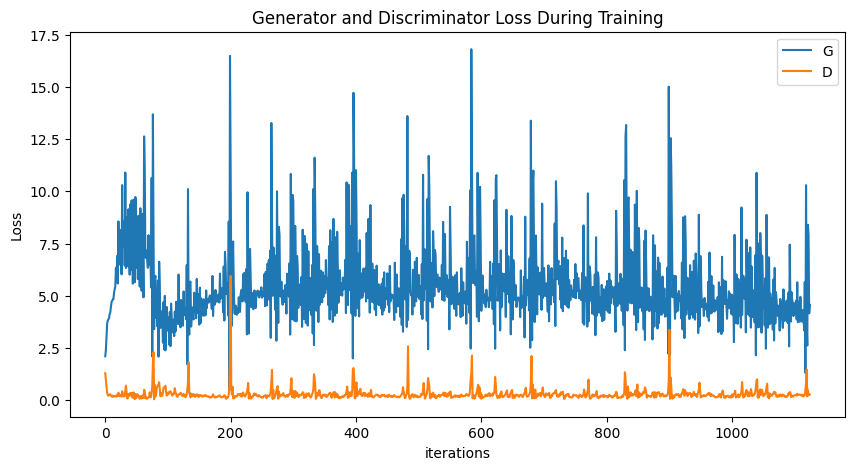

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

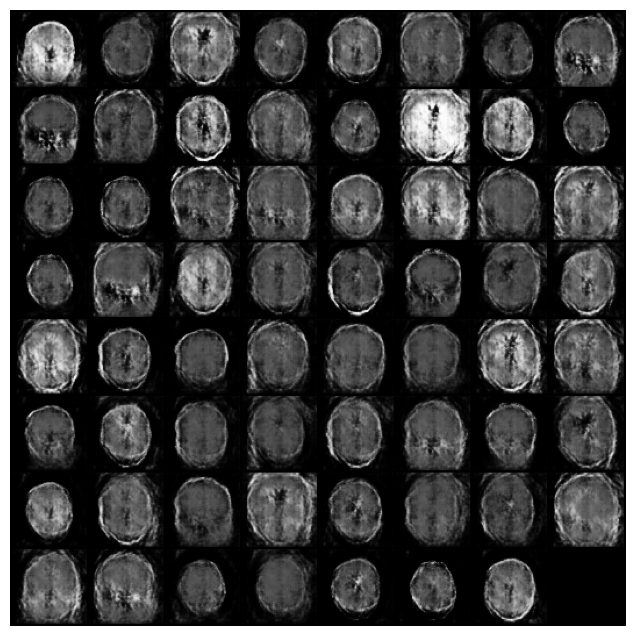

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())